In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.svm import LinearSVC
import sys
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.stem.porter import *
import string
import re
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import gc
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
stopwords = stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt",'abov', 'ani', 'becaus', 'befor', 
                    'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv',
                    'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv']
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
                       '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text


def tokenize(tweet):
    tweet = " ".join(re.split("[^a-zA-Z]+", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    # print(tokens)
    return tokens


def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]+", tweet.lower())).strip()
    return tweet.split()


vectorizer_david = TfidfVectorizer(tokenizer=tokenize,
                                   preprocessor=preprocess,
                                   ngram_range=(1, 3),
                                   stop_words=stopwords,
                                   use_idf=True,
                                   smooth_idf=False,
                                   norm=None,
                                   decode_error='replace',
                                   max_features=10000,
                                   min_df=5,
                                   max_df=0.75)

pos_vectorizer_david = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
)

sentiment_analyzer = VS()


def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
                       '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return (parsed_text.count('URLHERE'), parsed_text.count('MENTIONHERE'),
            parsed_text.count('HASHTAGHERE'))


def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    words = preprocess(tweet)  #Get text only
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables + 0.001)) / float(num_words + 0.001), 4)
    num_unique_terms = len(set(words.split()))

    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(
        float(0.39 * float(num_words) / 1.0) + float(11.8 * avg_syl) - 15.59,
        1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(
        206.835 - 1.015 * (float(num_words) / 1.0) - (84.6 * float(avg_syl)),
        2)

    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [
        FKRA, FRE, syllables, avg_syl, num_chars, num_chars_total, num_terms,
        num_words, num_unique_terms, sentiment['neg'], sentiment['pos'],
        sentiment['neu'], sentiment['compound'], twitter_objs[2],
        twitter_objs[1], twitter_objs[0], retweet
    ]
    #features = pandas.DataFrame(features)
    return features


def get_feature_array(tweets):
    feats = []
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [3]:
stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()

sentiment_analyzer = VS()

pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
)

vectorizer = TfidfVectorizer(tokenizer=basic_tokenize,
                             preprocessor=preprocess,
                             ngram_range=(1, 3),
                             stop_words=stopwords,
                             use_idf=True,
                             smooth_idf=False,
                             norm=None,
                             decode_error='replace',
                             max_features=10000,
                             min_df=5,
                             max_df=0.75)

davidson_model = LogisticRegression(class_weight='balanced', penalty='l2',solver='lbfgs', max_iter=1000)

#hate_map = {0: "NON HATE", 1: "HATE"}

In [4]:
def get_vectorisers(train_tweets):
    global vectorizer_david, pos_vectorizer_david
    vectorizer_david = vectorizer_david.fit(train_tweets)
    train_tweet_tags = get_tag_list(train_tweets)
    pos_vectorizer_david = pos_vectorizer_david.fit(
        pd.Series(train_tweet_tags))


def reset_vectorisers():
    global vectorizer_david, pos_vectorizer_david
    vectorizer_david = TfidfVectorizer(tokenizer=tokenize,
                                       preprocessor=preprocess,
                                       ngram_range=(1, 3),
                                       stop_words=stopwords,
                                       use_idf=True,
                                       smooth_idf=False,
                                       norm=None,
                                       decode_error='replace',
                                       max_features=10000,
                                       min_df=5,
                                       max_df=0.75)

    pos_vectorizer_david = TfidfVectorizer(
        tokenizer=None,
        lowercase=False,
        preprocessor=None,
        ngram_range=(1, 3),
        stop_words=None,
        use_idf=False,
        smooth_idf=False,
        norm=None,
        decode_error='replace',
        max_features=5000,
        min_df=5,
        max_df=0.75,
    )


def get_tag_list(tweets):
    tweet_tags = []
    for tweet in tweets:
        tokens = basic_tokenize(preprocess(tweet))
        tags = nltk.pos_tag(tokens)
        tag_list = [x[1] for x in tags]
        tag_str = " ".join(tag_list)
        tweet_tags.append(tag_str)
    return tweet_tags


def return_feature_set(tweets):
    global vectorizer_david, pos_vectorizer_david
    tfidf = vectorizer_david.transform(tweets).toarray()
    tweet_tags = get_tag_list(tweets)
    pos = pos_vectorizer_david.transform(pd.Series(tweet_tags)).toarray()
    feats = get_feature_array(tweets)
    feat_M = np.concatenate([tfidf, pos, feats], axis=1)
    del tfidf, pos, feats, tweet_tags
    gc.collect()
    return feat_M


def run_model(train_texts, train_labels):
    reset_vectorisers()
    get_vectorisers(train_texts)
    X_train = return_feature_set(train_texts)
    y_train = np.asarray(train_labels)
    oversample = SMOTE(random_state=777, k_neighbors=1)
    X, y = oversample.fit_resample(X_train,y_train)

    base_model = LogisticRegression(class_weight='balanced', penalty='l2',solver='lbfgs', max_iter=1000)
    base_model.fit(X, y)
    print("TRAIN ACCURACY")
    y_preds = base_model.predict(X)
    report = classification_report(y, y_preds)
    print(report)
    return base_model

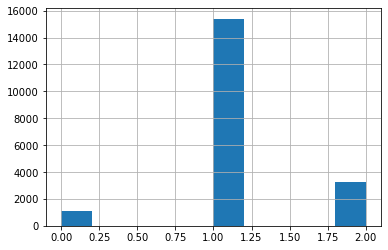

       tweet     id
label              
0       1137   1137
1      15398  15398
2       3291   3291


C:\Users\HP\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

TRAIN ACCURACY
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15398
           1       1.00      0.99      0.99     15398
           2       1.00      1.00      1.00     15398

    accuracy                           1.00     46194
   macro avg       1.00      1.00      1.00     46194
weighted avg       1.00      1.00      1.00     46194



In [5]:
from imblearn.over_sampling import SMOTE
david = pd.read_csv("D:/downloads_14/H3_Multiclass_Hate_Speech_Detection_train.csv")
david['label'].hist()
plt.show()
print(david.groupby('label').count())

train_text = david['tweet']
train_label = david['label']

model = run_model(train_text, train_label)

In [6]:
# submissions = pd.DataFrame({'Label':predictions})
test = pd.read_csv("D:/downloads_2611/H3_Multiclass_Hate_Speech_Detection_test.csv") #,encoding='unicode_escape'
train_texts = test['tweet']
#train_labels = david['Label']

train_texts = list(train_texts)
#train_labels = list(train_labels)

xg = return_feature_set(train_texts)
predictions = model.predict(xg)
submission = pd.DataFrame({'label':predictions,'id':test['id']})
#david['output'] = david[predictions]
file_name = 'D:/lr.csv'
submission.to_csv(file_name,index=False)

# # predictions = model.predict(vect_transformed_test)
# submission = pd.DataFrame({'id':test['id'],'label':predictions})
# # file_name = 'test_predictions.csv'
# # submission.to_csv(file_name,index=False)